# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Ivenho\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


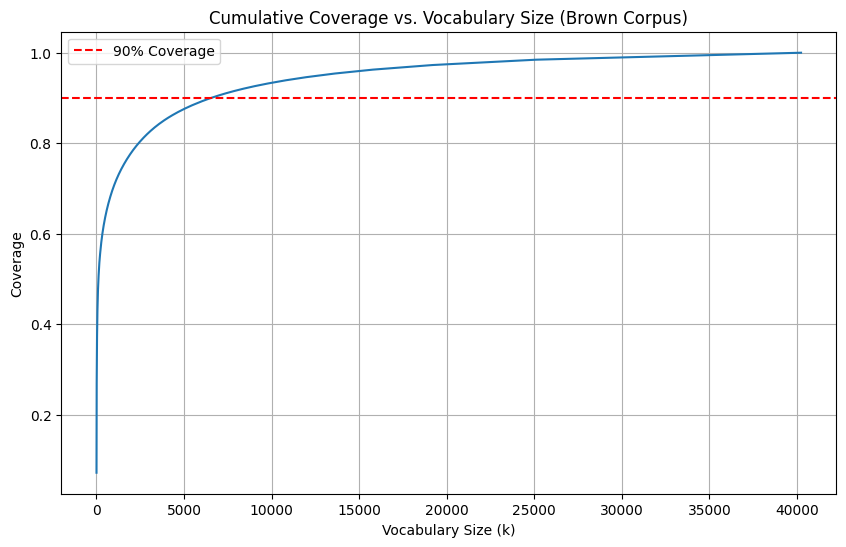

Appropriate vocabulary size (90% coverage): 6545


In [1]:
import nltk
from nltk.corpus import brown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# 1. Load the Brown corpus
nltk.download('brown')
words = [w.lower() for w in brown.words() if w.isalpha()] # берем только слова
word_counts = Counter(words)
total_unique_words = len(word_counts)

# Сортируем по частоте (f(r))
sorted_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_counts)
total_sum = sum(sorted_counts)
coverage = cumulative_sum / total_sum

# 2. Plot cumulative coverage
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Coverage')
plt.title('Cumulative Coverage vs. Vocabulary Size (Brown Corpus)')
plt.xlabel('Vocabulary Size (k)')
plt.ylabel('Coverage')
plt.grid(True)
plt.legend()
plt.show()

# 3. Select appropriate vocabulary size
vocab_size_90 = np.where(coverage >= 0.9)[0][0] + 1
print(f"Appropriate vocabulary size (90% coverage): {vocab_size_90}")

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [2]:
import re
from collections import defaultdict

class BPETokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges = {}
        self.vocab = set()

    def _get_stats(self, ids):
        """Подсчет частоты пар соседних токенов."""
        counts = defaultdict(int)
        for word_id_list in ids:
            for i in range(len(word_id_list) - 1):
                counts[(word_id_list[i], word_id_list[i+1])] += 1
        return counts

    def _merge(self, ids, pair, idx):
        """Замена пары токенов на новый токен везде в корпусе."""
        new_ids = []
        for word_id_list in ids:
            new_list = []
            i = 0
            while i < len(word_id_list):
                if i < len(word_id_list) - 1 and (word_id_list[i], word_id_list[i+1]) == pair:
                    new_list.append(idx)
                    i += 2
                else:
                    new_list.append(word_id_list[i])
                    i += 1
            new_ids.append(new_list)
        return new_ids

    def train(self, corpus):
        """Обучение токенизатора на списке строк."""
        # Начальная токенизация: разбиваем на символы и добавляем спецсимвол конца слова
        processed_corpus = [list(word) + ['</w>'] for word in corpus]
        
        # Создаем начальный маппинг символов в ID
        unique_chars = sorted(list(set([char for word in processed_corpus for char in word])))
        self.vocab = {i: char for i, char in enumerate(unique_chars)}
        self.inverse_vocab = {char: i for i, char in enumerate(unique_chars)}
        
        current_ids = [[self.inverse_vocab[char] for char in word] for word in processed_corpus]
        
        num_merges = self.vocab_size - len(unique_chars)
        for i in range(num_merges):
            stats = self._get_stats(current_ids)
            if not stats:
                break
            best_pair = max(stats, key=stats.get)
            new_token_id = len(self.vocab)
            
            current_ids = self._merge(current_ids, best_pair, new_token_id)
            self.merges[best_pair] = new_token_id
            
            # Обновляем словарь: новый токен = склейка двух старых
            self.vocab[new_token_id] = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]
            
        print(f"BPE Training complete. Final vocab size: {len(self.vocab)}")

    def tokenize(self, text):
        """Токенизация входной строки."""
        words = text.lower().split()
        tokens = []
        for word in words:
            # Начинаем с символов
            word_ids = [self.inverse_vocab.get(char, 0) for char in list(word) + ['</w>']]
            
            # Применяем выученные слияния в том же порядке
            while len(word_ids) >= 2:
                stats = [(word_ids[i], word_ids[i+1]) for i in range(len(word_ids)-1)]
                # Ищем пару, которая есть в self.merges и имеет минимальный ID (самая ранняя)
                pair_to_merge = None
                for pair in stats:
                    if pair in self.merges:
                        if pair_to_merge is None or self.merges[pair] < self.merges[pair_to_merge]:
                            pair_to_merge = pair
                
                if pair_to_merge is None:
                    break
                
                word_ids = self._merge([word_ids], pair_to_merge, self.merges[pair_to_merge])[0]
            
            tokens.extend([self.vocab[idx] for idx in word_ids])
        return tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
# 1. Train on Brown corpus
# Берем подвыборку для ускорения (например, первые 5000 слов), либо весь, если комп мощный
train_data = [w.lower() for w in brown.words()[:10000] if w.isalpha()]
tokenizer = BPETokenizer(vocab_size=vocab_size_90)
tokenizer.train(train_data)

# 2. Calculate fertility and length
test_sentences = brown.sents()[:1000]
fertilities = []
lengths = []

for sent in test_sentences:
    original_word_count = len(sent)
    tokenized = tokenizer.tokenize(" ".join(sent))
    
    fertility = len(tokenized) / original_word_count
    fertilities.append(fertility)
    lengths.append(len(tokenized))

print(f"Mean Fertility: {np.mean(fertilities):.2f}, Std: {np.std(fertilities):.2f}")
print(f"Mean Tokenized Length: {np.mean(lengths):.2f}, Std: {np.std(lengths):.2f}")

BPE Training complete. Final vocab size: 4488
Mean Fertility: 1.46, Std: 0.37
Mean Tokenized Length: 31.41, Std: 17.54


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.